# Optimization with a Gaussian Process Surrogate Model

- Model: two independent Gaussian Processes from the smt library
- Modelled variables: English and Spanish sales
- Optimized variables: profit, profit / sd(profit)

In [1]:
import os
import sys
from functools import partial

import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import minimize_scalar
from sklearn.metrics import r2_score
from smt.surrogate_models import KRG

sys.path.append("../src")
from preprocessing import prepare_data
from plot_estimated_reading import plot_reading_for_2d_allocation, plot_optimization_improvement
from estimate_reading import reading_function, compute_reading_for_proportion

## Prepare data for modeling

In [2]:
df_raw = pd.read_csv("../data/raw_reading_samples.csv")
df = prepare_data(df_raw, format_to_long=True)
df.head(5)

,reading_fiction,reading_help,free_fiction,free_help,total_reading
0,9.342691,9.983322,0.0,0.0,19.326013
1,9.515911,11.093644,0.0,0.0,20.609556
2,11.628954,7.527137,0.0,0.0,19.156091
3,9.763141,10.031910,0.0,0.0,19.795051
4,9.741243,9.705921,0.0,0.0,19.447164


## Modeling

In [3]:
X = df[['free_fiction', 'free_help']].values
Y_fiction = df['reading_fiction'].values
Y_help = df['reading_help'].values

In [4]:
# training the surrogate model for English
sm_fiction = KRG(use_het_noise=True, eval_noise=True, print_global=False)
sm_fiction.set_training_values(X, Y_fiction)
sm_fiction.train()
# training the surrogate model for Spanish
sm_help = KRG(use_het_noise=True, eval_noise=True, print_global=False)
sm_help.set_training_values(X, Y_help)
sm_help.train()

In [5]:
joblib.dump(sm_fiction, "../models/smt_gaussianProcess_fiction.joblib")
joblib.dump(sm_help, "../models/smt_gaussianProcess_help.joblib")

['../models/smt_gaussianProcess_help.joblib']

In [6]:
#predictions
Y_predict_fiction = sm_fiction.predict_values(X)
var_fiction = sm_fiction.predict_variances(X)
Y_predict_help = sm_help.predict_values(X)
var_help = sm_help.predict_variances(X)

# Evaluate fit
print(r2_score(Y_fiction, Y_predict_fiction), r2_score(Y_help, Y_predict_help)) 

# Evaluate fit on total reading time
Y_reading = Y_predict_fiction + Y_predict_help
print(r2_score(Y_reading, df.total_reading))

0.9990496737056678 0.9993194221849707
0.9993074944319931


## Plot profit function
### 1. Sample predictions over allocations of the whole budget

In [7]:
# Sample space and create budget allocations all over it
total_budget = 120
prop_fiction = np.arange(start=0, stop=1.01, step=0.01)
budget = np.array(np.array([prop_fiction, (1 - prop_fiction)]) * total_budget).transpose()

# Predict reading time
reading_fiction = sm_fiction.predict_values(budget)
var_fiction = sm_fiction.predict_variances(budget)
reading_help = sm_help.predict_values(budget)
var_help = sm_help.predict_variances(budget)

# Compute expected reading and std of reading
reading = reading_fiction + reading_help
var_reading = var_fiction + var_help #+ 2 * 30 * 20 * cov Ignore covariance for simplicity
sd_reading = np.sqrt(var_reading)

df_predictions = pd.DataFrame()
df_predictions['prop_budget_fiction'] = prop_fiction
df_predictions['predicted_reading_fiction'] = reading_fiction
df_predictions['predicted_reading_help'] = reading_help
df_predictions['reading'] = reading
df_predictions['var_reading'] = var_reading
df_predictions['Std reading'] = np.sqrt(df_predictions['var_reading'])
df_predictions['reading / std'] = df_predictions['reading'] / np.sqrt(df_predictions['var_reading'])

In [8]:
# Plot reading time for various proportions between Fiction and Self-help
fig = px.scatter(df_predictions, x="prop_budget_fiction", y=["predicted_reading_fiction", "predicted_reading_help"])
fig.update_layout(
    title="Expected reading time for all allocations of the 120 free minutes",
    title_x=0.5,
    xaxis_title="Proportion of the budget for fiction",
    yaxis_title="Reading Time",
    legend_title="Variable",
)
fig.show()

In [9]:
# Plot expected total reading time for various proportions between Fiction and Self-help
fig = px.scatter(df_predictions, x="prop_budget_fiction", y="reading")
fig.update_layout(
    title="Expected reading time for all allocations of the 120 free minutes",
    title_x=0.5,
    xaxis_title="Proportion of the budget for fiction",
    yaxis_title="Total Reading Time",
    legend_title="Variable",
)
fig.show()

In [10]:
# Plot std of total reading time for various proportions between Fiction and Self-help
fig = px.scatter(df_predictions, x="prop_budget_fiction", y="Std reading")
fig.update_layout(
    title="Std reading time for all allocations of the 120 free minutes",
    title_x=0.5,
    xaxis_title="Proportion of the budget for fiction",
    yaxis_title="Std of Reading Time",
    legend_title="Variable",
)
fig.show()

In [11]:
# Plot Sharpe ratio of total reading time for various proportions between Fiction and Self-help
fig = px.scatter(df_predictions, x="prop_budget_fiction", y="reading / std")
fig.update_layout(
    title="Sharpe ratio of the reading time for all allocations of the 120 free minutes",
    title_x=0.5,
    xaxis_title="Proportion of the budget for fiction",
    yaxis_title="Sharpe ratio of Reading Time",
    legend_title="Variable",
)
fig.show()

### 2. Observe estimated variability over all possible allocations 

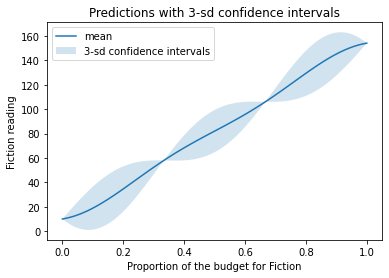

In [12]:
plt.fill_between(
    np.ravel(prop_fiction), 
    np.ravel(reading_fiction - 3 * np.sqrt(var_fiction)),
    np.ravel(reading_fiction + 3 * np.sqrt(var_fiction)), 
    alpha=0.2,
    label='3-sd confidence intervals'
)
plt.plot(prop_fiction, reading_fiction, label='mean')
plt.title('Predictions with 3-sd confidence intervals')
plt.legend(loc=0)
plt.xlabel('Proportion of the budget for Fiction')
plt.ylabel('Fiction reading')
plt.show()

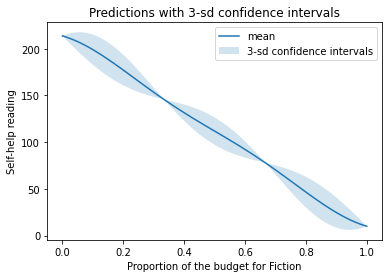

In [13]:
plt.fill_between(
    np.ravel(prop_fiction), 
    np.ravel(reading_help - 3 * np.sqrt(var_help)),
    np.ravel(reading_help + 3 * np.sqrt(var_help)), 
    alpha=0.2,
    label='3-sd confidence intervals'
)
plt.plot(prop_fiction, reading_help, label='mean')
plt.title('Predictions with 3-sd confidence intervals')
plt.legend(loc=0)
plt.xlabel('Proportion of the budget for Fiction')
plt.ylabel('Self-help reading')
plt.show()

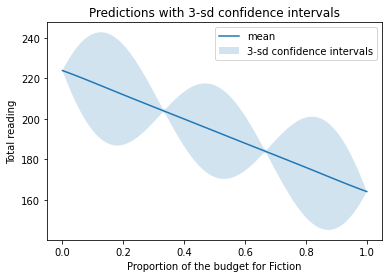

In [14]:
plt.fill_between(
    np.ravel(prop_fiction), 
    np.ravel(reading - 3 * np.sqrt(var_reading)),
    np.ravel(reading + 3 * np.sqrt(var_reading)), 
    alpha=0.2,
    label='3-sd confidence intervals'
)
plt.plot(prop_fiction, reading, label='mean')
plt.legend(loc=0)
plt.title('Predictions with 3-sd confidence intervals')
plt.xlabel('Proportion of the budget for Fiction')
plt.ylabel('Total reading')
plt.show()

### 3. Sample predictions over budgets for each product below 1 million €

In [15]:
plot_reading_for_2d_allocation(
    max_time=120, 
    estimators=(sm_fiction, sm_help), 
    type_estimator="smt_kriging", 
    sampling_step=10
)

In [16]:
plot_reading_for_2d_allocation(
    max_time=120, 
    estimators=(sm_fiction, sm_help), 
    type_estimator="smt_kriging", 
    sampling_step=10,
    estimator_sd=(sm_fiction, sm_help)
)

Cf the notebook FormalizationOfTheProblem for a comment on this result.